# Ensemble Assesment - Boosting and Gradient Boosting

---
## Import modules

In [1]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn import metrics

from sklearn.inspection import permutation_importance

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

# others
from mltools import model_tools as MT

---
## Load data and split into train and test sets
Data is loaded from the processed data file and split into train and test sets. The train set is used to train the model and the test set is used to evaluate the model.

In [2]:
# Load data
file_path = 'data/input.csv'
df = pd.read_csv(file_path)
df.head(10)

,MES_x,DIA_x,HOUR,IRRAD_VALUE,UTIL_VALUE,dia_mes
0,1,1,0,0.0,0.000023,1
1,1,2,0,0.0,0.000012,2
2,1,3,0,0.0,0.000008,3
3,1,4,0,0.0,0.000008,4
4,1,5,0,0.0,0.000008,5
5,1,6,0,0.0,0.000012,6
6,1,7,0,0.0,0.000000,7
7,1,8,0,0.0,0.000000,8
8,1,9,0,0.0,0.000004,9
9,1,10,0,0.0,0.000000,10


In [3]:
## Split the dataset into training and test sets

# Define input and output matrices
INPUTS = df.columns[~df.columns.isin(['UTIL_VALUE'])]
OUTPUT = 'UTIL_VALUE'

# Split
X_train, X_test, y_train, y_test = train_test_split(df[INPUTS], df[OUTPUT],
                                                    test_size=0.2, # percentage of test data
                                                    random_state=0) # seed for replication

# Check the shape of the resulting dataframes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14028, 5), y_train shape: (14028,)
X_test shape: (3508, 5), y_test shape: (3508,)


---
## Adaboost

In [20]:
## Fit an AdaBoost model

# Parameters
parameters_ab = {'n_estimators': [100, 500, 1000, 5000],
                 'base_estimator__max_depth': [2, 4, 6],
                 'base_estimator__min_impurity_decrease': [0.0, 0.0001, 0.001]}

# Model definition
model_ab = AdaBoostRegressor(DecisionTreeRegressor(), random_state=0)

# Grid search
nFolds = 10
model_ab_fit = GridSearchCV(estimator=model_ab,
                              param_grid=parameters_ab,
                              cv=nFolds,
                              n_jobs=-1) # use all processors (parallelize)

# Fit the model
model_ab_fit.fit(X_train, y_train)

c:\Users\elena\anaconda3\envs\ML\Lib\site-packages\sklearn\model_selection\_search.py:929: FutureWarning: Parameter 'base_estimator' of AdaBoostRegressor is deprecated in favor of 'estimator'. See AdaBoostRegressor's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


GridSearchCV(cv=10,
             estimator=AdaBoostRegressor(estimator=DecisionTreeRegressor(),
                                         random_state=0),
             n_jobs=-1,
             param_grid={'base_estimator__max_depth': [2, 4, 6],
                         'base_estimator__min_impurity_decrease': [0.0, 0.0001,
                                                                   0.001],
                         'n_estimators': [100, 500, 1000, 5000]})

In [21]:
# Show the best parameters
model_ab_fit.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__base_estimator': 'deprecated',
 'estimator__estimator__ccp_alpha': 0.0,
 'estimator__estimator__criterion': 'squared_error',
 'estimator__estimator__max_depth': None,
 'estimator__estimator__max_features': None,
 'estimator__estimator__max_leaf_nodes': None,
 'estimator__estimator__min_impurity_decrease': 0.0,
 'estimator__estimator__min_samples_leaf': 1,
 'estimator__estimator__min_samples_split': 2,
 'estimator__estimator__min_weight_fraction_leaf': 0.0,
 'estimator__estimator__random_state': None,
 'estimator__estimator__splitter': 'best',
 'estimator__estimator': DecisionTreeRegressor(),
 'estimator__learning_rate': 1.0,
 'estimator__loss': 'linear',
 'estimator__n_estimators': 50,
 'estimator__random_state': 0,
 'estimator': AdaBoostRegressor(estimator=DecisionTreeRegressor(), random_state=0),
 'n_jobs': -1,
 'param_grid': {'n_estimators': [100, 500, 1000, 5000],
  'base_estimator__max_depth': [2, 4, 6],
  'base_estimator__min_impurity_

In [22]:
## Predict
y_train_pred_ab = model_ab_fit.predict(X_train)
y_test_pred_ab = model_ab_fit.predict(X_test)

In [23]:
## Evaluate performance of the AdaBoost model

# Mean Squared Error
mse_train_ab = metrics.mean_squared_error(y_train, y_train_pred_ab)
mse_test_ab = metrics.mean_squared_error(y_test, y_test_pred_ab)

# Root Mean Squared Error
rmse_train_ab = np.sqrt(mse_train_ab)
rmse_test_ab = np.sqrt(mse_test_ab)

# R2
r2_train_ab = metrics.r2_score(y_train, y_train_pred_ab)
r2_test_ab = metrics.r2_score(y_test, y_test_pred_ab)

# Mean Absolute Error
mae_train_ab = metrics.mean_absolute_error(y_train, y_train_pred_ab)
mae_test_ab = metrics.mean_absolute_error(y_test, y_test_pred_ab)

# Dataframe with results
results_ab = pd.DataFrame({'Metric': ['MSE', 'RMSE', 'R2', 'MAE'],
                        'Train': [mse_train_ab, rmse_train_ab, r2_train_ab, mae_train_ab],
                        'Test': [mse_test_ab, rmse_test_ab, r2_test_ab, mae_test_ab]})
results_ab

,Metric,Train,Test
0,MSE,0.008677,0.009104
1,RMSE,0.093149,0.095413
2,R2,0.854794,0.850736
3,MAE,0.079243,0.080483


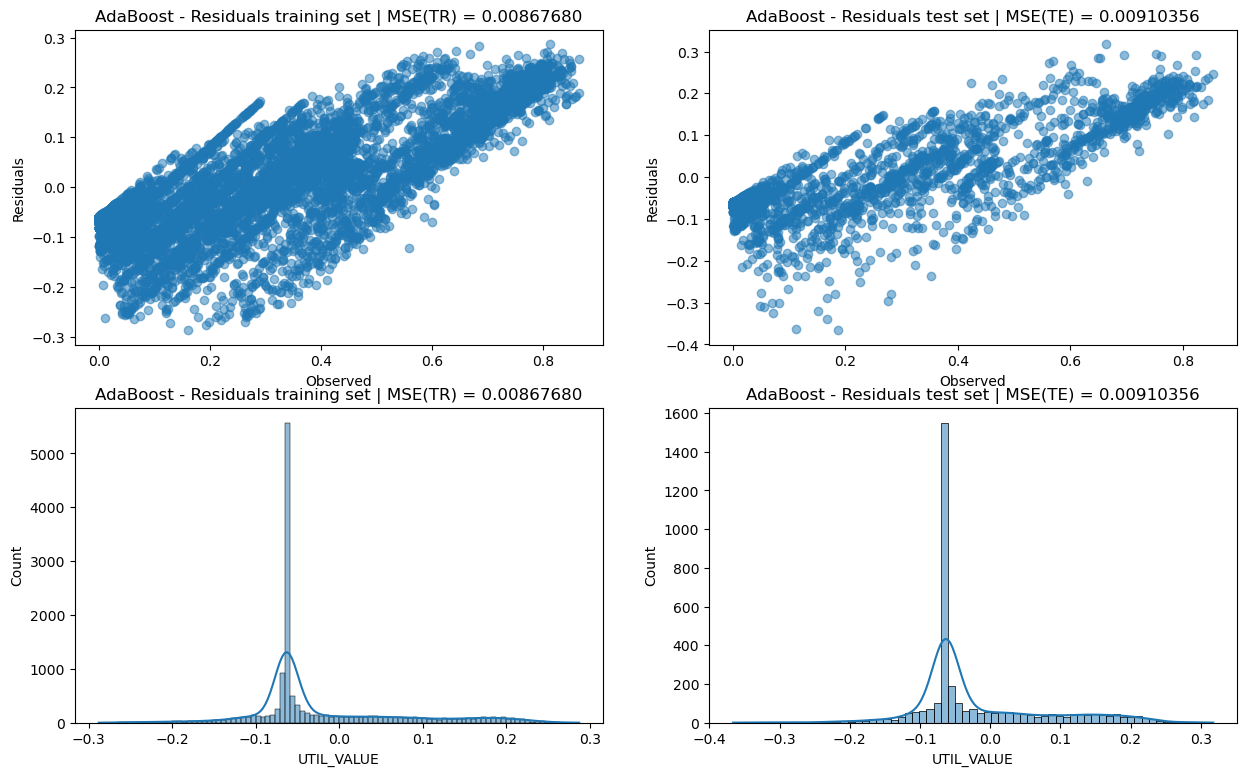

In [24]:
## Plot residuals (scatter and histogram) of the AdaBoost model
plt.figure(figsize=(15, 9))

# Calculate residuals
residuals_train_ab = y_train - y_train_pred_ab
residuals_test_ab = y_test - y_test_pred_ab

# Scatter plots
plt.subplot(2, 2, 1)
plt.scatter(y_train, residuals_train_ab, alpha=0.5)
plt.title(f'AdaBoost - Residuals training set | MSE(TR) = {mse_train_ab:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_test, residuals_test_ab, alpha=0.5)
plt.title(f'AdaBoost - Residuals test set | MSE(TE) = {mse_test_ab:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

# Histograms
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_ab, kde=True)
plt.title(f'AdaBoost - Residuals training set | MSE(TR) = {mse_train_ab:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_ab, kde=True)
plt.title(f'AdaBoost - Residuals test set | MSE(TE) = {mse_test_ab:.8f}')

# Show plot
plt.show()

---
## Gradient Boosting

In [25]:
## Fit a Gradient Boosting model

# Parameters
parameters_gb = {'n_estimators': [100, 500, 1000, 5000],
                    'learning_rate': [0.01, 0.1, 0.5],
                    'max_depth': [1, 2, 3],
                    'min_impurity_decrease': [0.0, 0.0001, 0.001]}

# Model definition
model_gb = GradientBoostingRegressor(max_features=1.0,
                                        loss='squared_error',
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        random_state=0)

# Grid search
nFolds = 10
model_gb_fit = GridSearchCV(estimator=model_gb,
                            param_grid=parameters_gb,
                            cv=nFolds,
                            n_jobs=-1) # parallelize

# Fit the model
model_gb_fit.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=GradientBoostingRegressor(max_features=1.0,
                                                 random_state=0),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [1, 2, 3],
                         'min_impurity_decrease': [0.0, 0.0001, 0.001],
                         'n_estimators': [100, 500, 1000, 5000]})

In [26]:
# Show the best parameters
model_gb_fit.get_params()

{'cv': 10,
 'error_score': nan,
 'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'squared_error',
 'estimator__max_depth': 3,
 'estimator__max_features': 1.0,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': 0,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(max_features=1.0, random_state=0),
 'n_jobs': -1,
 'param_grid': {'n_estimators': [100, 500, 1000, 5000],
  'learning_rate': [0.01, 0.1, 0.5],
  'max_depth': [1, 2, 3],
  'min_impurity_decrease': [0.0, 0.0001, 0.001]},
 '

In [27]:
## Predict
y_train_pred_gb = model_gb_fit.predict(X_train)
y_test_pred_gb = model_gb_fit.predict(X_test)

In [28]:
## Evaluate performance of the Gradient Boosting model

# Mean Squared Error
mse_train_gb = metrics.mean_squared_error(y_train, y_train_pred_gb)
mse_test_gb = metrics.mean_squared_error(y_test, y_test_pred_gb)

# Root Mean Squared Error
rmse_train_gb = np.sqrt(mse_train_gb)
rmse_test_gb = np.sqrt(mse_test_gb)

# R2
r2_train_gb = metrics.r2_score(y_train, y_train_pred_gb)
r2_test_gb = metrics.r2_score(y_test, y_test_pred_gb)

# Mean Absolute Error
mae_train_gb = metrics.mean_absolute_error(y_train, y_train_pred_gb)
mae_test_gb = metrics.mean_absolute_error(y_test, y_test_pred_gb)

# Dataframe with results
results_gb = pd.DataFrame({'Metric': ['MSE', 'RMSE', 'R2', 'MAE'],
                        'Train': [mse_train_gb, rmse_train_gb, r2_train_gb, mae_train_gb],
                        'Test': [mse_test_gb, rmse_test_gb, r2_test_gb, mae_test_gb]})
results_gb

,Metric,Train,Test
0,MSE,0.003192,0.004205
1,RMSE,0.056498,0.064844
2,R2,0.946582,0.931057
3,MAE,0.030974,0.035405


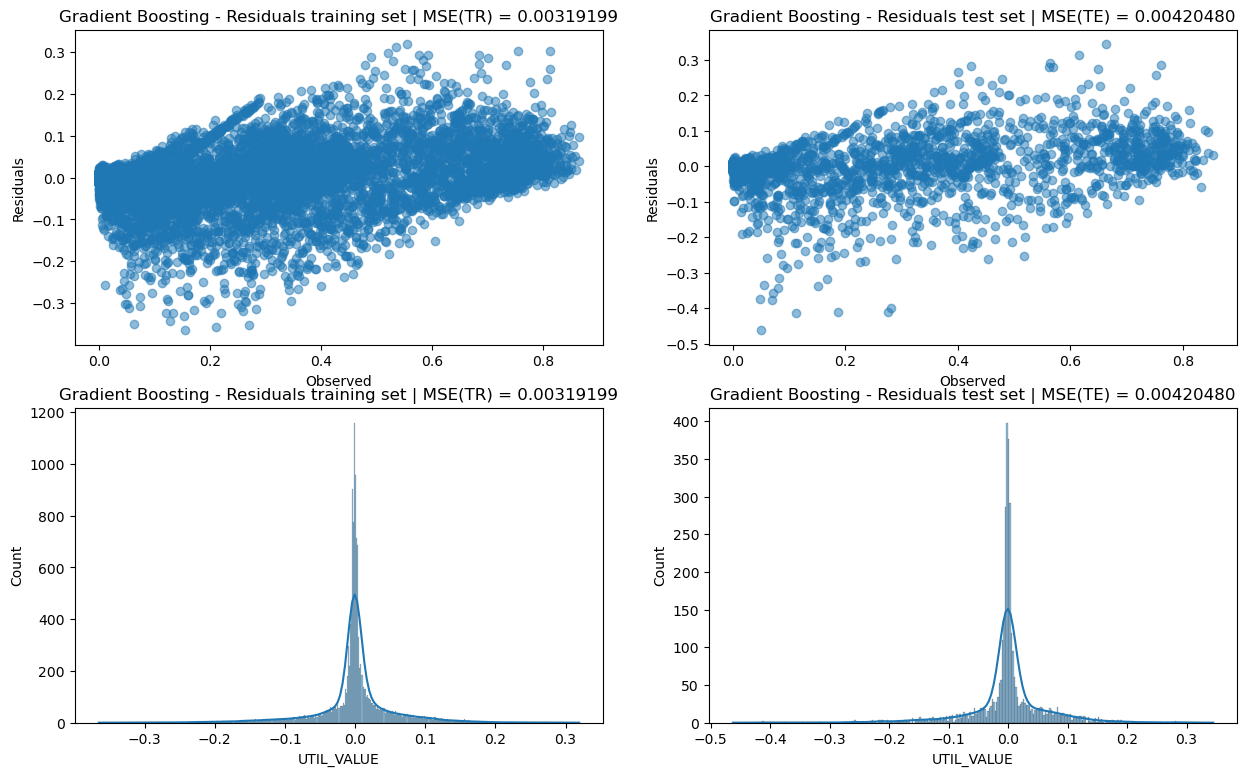

In [29]:
## Plot residuals (scatter and histogram) of the Gradient Boosting model
plt.figure(figsize=(15, 9))

# Calculate residuals
residuals_train_gb = y_train - y_train_pred_gb
residuals_test_gb = y_test - y_test_pred_gb

# Scatter plots
plt.subplot(2, 2, 1)
plt.scatter(y_train, residuals_train_gb, alpha=0.5)
plt.title(f'Gradient Boosting - Residuals training set | MSE(TR) = {mse_train_gb:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

plt.subplot(2, 2, 2)
plt.scatter(y_test, residuals_test_gb, alpha=0.5)
plt.title(f'Gradient Boosting - Residuals test set | MSE(TE) = {mse_test_gb:.8f}')
plt.xlabel('Observed')
plt.ylabel('Residuals')

# Histograms
plt.subplot(2, 2, 3)
sns.histplot(residuals_train_gb, kde=True)
plt.title(f'Gradient Boosting - Residuals training set | MSE(TR) = {mse_train_gb:.8f}')

plt.subplot(2, 2, 4)
sns.histplot(residuals_test_gb, kde=True)
plt.title(f'Gradient Boosting - Residuals test set | MSE(TE) = {mse_test_gb:.8f}')

# Show plot
plt.show()

---
## Comparison of Adaboost and Gradient Boosting

In [30]:
## Compare AdaBoost and Gradient Boosting models
results = pd.DataFrame({'Metric': ['MSE (Train)', 'MSE (Test)', 'RMSE (Train)', 'RMSE (Test)', 'R2 (Train)', 'R2 (Test)', 'MAE (Train)', 'MAE (Test)'],
                        'AdaBoost': [mse_train_ab, mse_test_ab, rmse_train_ab, rmse_test_ab, r2_train_ab, r2_test_ab, mae_train_ab, mae_test_ab],
                        'Gradient Boosting': [mse_train_gb, mse_test_gb, rmse_train_gb, rmse_test_gb, r2_train_gb, r2_test_gb, mae_train_gb, mae_test_gb]})
results.set_index('Metric', inplace=True)
results

,AdaBoost,Gradient Boosting
Metric,,
MSE (Train),0.008677,0.003192
MSE (Test),0.009104,0.004205
RMSE (Train),0.093149,0.056498
RMSE (Test),0.095413,0.064844
R2 (Train),0.854794,0.946582
R2 (Test),0.850736,0.931057
MAE (Train),0.079243,0.030974
MAE (Test),0.080483,0.035405
